In [8]:
import sys; sys.path.append('../..')
import numpy as np, elastic_rods
from bending_validation import suppress_stdout
from linkage_vis import LinkageViewer
import deployment_plots

l = elastic_rods.RodLinkage('pav_final190824__flat_opt.obj')
driver=l.centralJoint()

mat = elastic_rods.RodMaterial('Rectangle', 40000, 0.3, [12,8], stiffAxis=elastic_rods.StiffAxis.D1)
l.setMaterial(mat)

l.setPerSegmentRestLength(np.loadtxt('restlen_pav_final190824__flat_opt.txt'))

jdo = l.dofOffsetForJoint(driver)
fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
with suppress_stdout(): elastic_rods.compute_equilibrium(l, fixedVars=fixedVars)

view = LinkageViewer(l, width=1024, labelOffset=-0.5)
view.show()

Renderer(camera=PerspectiveCamera(aspect=2.0, children=(DirectionalLight(color='white', intensity=0.6, positio…

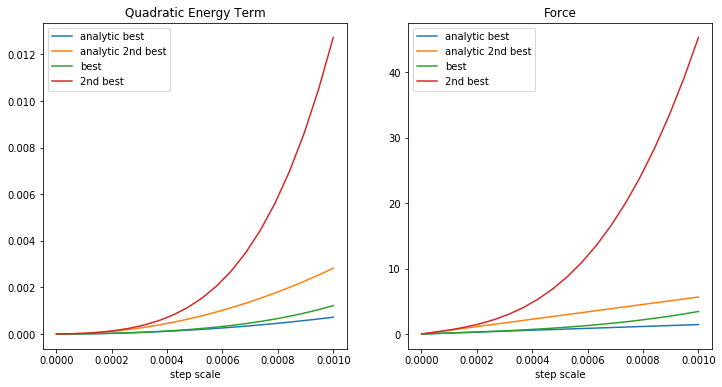

In [3]:
import deployment_path_analysis
dpa = deployment_path_analysis.deploymentPathAnalysis(l)
deployment_path_analysis.validateEnergyIncrements(l, epsMax=1e-2)

In [4]:
deployAngle = np.deg2rad(90)

In [8]:
openingAngles, stiffnessGaps = deployment_path_analysis.stiffnessGapThroughoutDeployment(l, deployAngle, 100)
view.update()

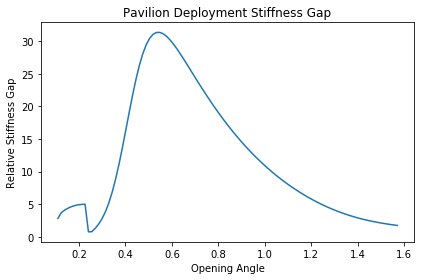

In [23]:
from matplotlib import pyplot as plt
plt.plot(openingAngles, stiffnessGaps)
plt.ylabel('Relative Stiffness Gap')
plt.xlabel('Opening Angle')
plt.title('Pavilion Deployment Stiffness Gap')
plt.tight_layout()
plt.savefig('stiffness_gap_pavilion.pdf')
plt.show()

In [11]:
np.min(stiffnessGaps)

0.7552006035122136

In [16]:
stiffnessGaps[-1]

1.7378374994880472

In [12]:
m = deployment_path_analysis.deploymentModeViewer(l)

In [14]:
m.setAmplitude(0.1)

In [13]:
m.show()

In [2]:
# Output fabrication data
from linkage_utils import writeRodSegments
writeRodSegments(l,'rodSegments_postdeploy.txt', zeroBasedIndexing=True)
#np.savetxt('restlen_meshID_1935b524-e979-4340-9245-326f69b6eae0.txt',l.getPerSegmentRestLength())

In [6]:
postoptStressRecorder = deployment_plots.StressRecorder()

In [4]:
mkdir deployment_frames

mkdir: cannot create directory ‘deployment_frames’: File exists


In [7]:
from open_linkage import open_linkage
def equilibriumSolver(tgtAngle, l, opts, fv):
    opts.beta = 1e-8
    opts.gradTol = 1e-4
    opts.useIdentityMetric = False
    return elastic_rods.compute_equilibrium(l, tgtAngle, options=opts, fixedVars=fv)
with suppress_stdout(): cr, actuationForces, tgtAngles = open_linkage(l, driver, deployAngle - l.averageJointAngle, 50, view, zPerturbationEpsilon=0, equilibriumSolver=equilibriumSolver,
                                                                      maxNewtonIterationsIntermediate=20, verbose=10, useTargetAngleConstraint=True, outPathFormat='deployment_frames/frame_{}.msh',
                                                                      iterationCallback=postoptStressRecorder.log);

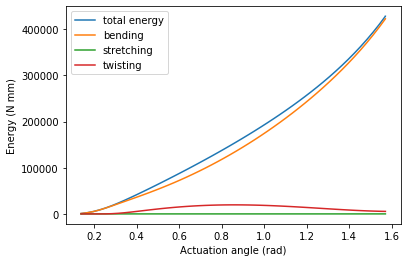

In [10]:
deployment_plots.energy_plot(tgtAngles, cr)

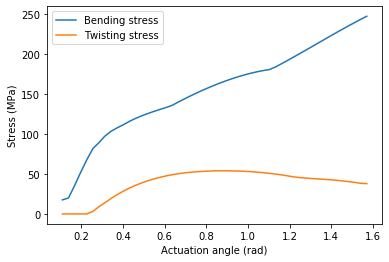

In [11]:
deployment_plots.stress_plot(postoptStressRecorder)

## Extract "free body diagram" for pieces of rods around joints

We consider joints with the greatest bending stress, twisting stress, torque magnitude or force magnitude

In [12]:
import importlib, structural_analysis
importlib.reload(structural_analysis)
from structural_analysis import Load, isolateRodPieceAtJoint, getLoadOnEdge, freeBodyDiagramReport

stretchingStresses = np.array([s.rod.stretchingStresses() for s in l.segments()])
# Get the (min, max) bending z-stress over the cross-section.
bendingStresses = np.array([s.rod.bendingStresses() for s in l.segments()])
# Get the principal stresses due to the shearing caused by rod torsion.
twistingStresses = np.array([s.rod.twistingStresses() for s in l.segments()])

In [13]:
np.max(bendingStresses[:,:, 0]), np.max(twistingStresses[:, :]), np.max(stretchingStresses[:, :])

(247.34624787179928, 37.87211452914496, 3.2189565683893306)

In [14]:
sojr = structural_analysis.stressesOnJointRegions(l, edgeDist=1)

In [15]:
def argmax2d(a): return np.unravel_index(a.argmax(), a.shape)
def argmin2d(a): return np.unravel_index(a.argmin(), a.shape)
argmax2d(sojr[0]), argmin2d(sojr[1]), argmax2d(sojr[2])

((50, 0), (50, 0), (111, 1))

In [16]:
freeBodyDiagramReport(l, 50, 0)

Rod segment(s) [48, 176] around joint 50 at [23665.54751222  4588.90342106   930.44238443], normal [-0.8989281   0.0795313   0.43081671]
Centerline points:
 [[23644.36398905  4641.49047084   880.58949824]
 [23651.17646315  4625.89004943   895.57352056]
 [23657.61231423  4610.13769355   910.56507013]
 [23663.66216455  4594.20743152   925.52932788]
 [23667.43285989  4583.5994106    935.35544097]
 [23671.01523356  4572.92462653   945.18074336]
 [23674.41617448  4562.19293      955.00853161]
 [23677.64233431  4551.41340403   964.84290874]]

Centerline tangents:
 [[ 0.30039657 -0.68790178  0.66072161]
 [ 0.28378946 -0.69460162  0.6610538 ]
 [ 0.26676885 -0.70244676  0.65985069]
 [ 0.25233434 -0.70988709  0.65756194]
 [ 0.23972102 -0.71432251  0.6574779 ]
 [ 0.22758004 -0.71813067  0.65764403]
 [ 0.21588419 -0.72133105  0.65808474]]

Cross-section frame vectors d1:
 [[0.34341449 0.72426172 0.59792261]
 [0.34809918 0.71699412 0.60394237]
 [0.35334651 0.70827355 0.61114223]
 [0.35812797 0.6998

In [17]:
dc = l.segment(0).rod.deformedConfiguration()

In [18]:
dc.materialFrame[0].d1

array([-0.46652374, -0.80690611,  0.36229563])

In [19]:
freeBodyDiagramReport(l, 111, 1)

Rod segment(s) [187] around joint 111 at [23788.55763264  4989.36728134  1844.28467186], normal [-0.91783378 -0.32786487 -0.22379853]
Centerline points:
 [[23773.74941446  5040.60447663  1828.38063603]
 [23778.06353027  5025.97883051  1832.8905051 ]
 [23782.312985    5011.34364779  1837.43072782]
 [23786.49772008  4996.69713486  1841.99446865]
 [23790.61754519  4982.03742782  1846.57487507]]

Centerline tangents:
 [[ 0.27130119 -0.91976094  0.2836115 ]
 [ 0.26723485 -0.92036062  0.28552033]
 [ 0.26316482 -0.92107311  0.2869993 ]
 [ 0.25908283 -0.92190282  0.28804734]]

Cross-section frame vectors d1:
 [[ 0.28297154 -0.20541995 -0.93687232]
 [ 0.28901114 -0.20610638 -0.93487578]
 [ 0.29494027 -0.20643117 -0.93295038]
 [ 0.3007611  -0.20639722 -0.93109771]]

Actuation torque:	 5279.001451409385
Out of plane torque from rivet (shear torque):	 8355.736656873589
Load on joint edge:
Net force: [ 23.19154421 -99.26590945 107.85708858]
   torque: [-1609.8246082  -8947.25746303 -3878.30375603] 

In [20]:
(np.argmax(np.linalg.norm(l.rivetNetForceAndTorques()[:, 0:3], axis=1)),
 np.argmax(np.linalg.norm(l.rivetNetForceAndTorques()[:, 3:6], axis=1)))

(45, 105)

In [21]:
freeBodyDiagramReport(l, 45, 0)

Rod segment(s) [184, 116] around joint 45 at [23727.2502476   5226.02179029  1562.66984636], normal [-0.92366978 -0.38291639  0.01446311]
Centerline points:
 [[23732.85579615  5207.44420466  1509.86132323]
 [23731.51389125  5212.7648957   1524.97191099]
 [23729.9745676   5218.0742503   1540.0676546 ]
 [23728.22972076  5223.37485355  1555.1441017 ]
 [23726.27077444  5228.66872703  1570.19559102]
 [23723.00088131  5236.63151989  1592.59774337]
 [23719.32272316  5244.62453503  1614.92570434]
 [23715.24383385  5252.60729224  1637.18763265]]

Centerline tangents:
 [[-0.08347215  0.33096945  0.93994235]
 [-0.09575245  0.33026433  0.93901914]
 [-0.10853688  0.32972002  0.93781899]
 [-0.12186191  0.32932067  0.9363213 ]
 [-0.1362509   0.33179608  0.93345972]
 [-0.15326258  0.33305531  0.93036807]
 [-0.16996033  0.33262782  0.92761642]]

Cross-section frame vectors d1:
 [[ 0.37177099 -0.86479164  0.33752297]
 [ 0.36897279 -0.86437506  0.34163552]
 [ 0.36614906 -0.86380946  0.34607525]
 [ 0.3632

In [22]:
freeBodyDiagramReport(l, 105, 0)

Rod segment(s) [176] around joint 105 at [23692.50164893  4491.6581431   1019.2679823 ], normal [-0.90605224  0.1658912   0.38929351]
Centerline points:
 [[23683.59483702  4529.74600655   984.54949724]
 [23686.33238532  4518.87524258   994.43149438]
 [23688.91755456  4507.99095003  1004.33960655]
 [23691.35487134  4497.10141109  1014.27937953]
 [23693.64842653  4486.21487511  1024.25658507]]

Centerline tangents:
 [[ 0.18318777 -0.72743594  0.6612709 ]
 [ 0.17299104 -0.72834112  0.66301834]
 [ 0.16309722 -0.72869212  0.6651369 ]
 [ 0.15347715 -0.72849111  0.66764172]]

Cross-section frame vectors d1:
 [[0.38341773 0.67225173 0.63329965]
 [0.38717206 0.66926215 0.63418133]
 [0.39081506 0.66673352 0.63461012]
 [0.39435275 0.66466594 0.6345905 ]]

Actuation torque:	 5279.001451135958
Out of plane torque from rivet (shear torque):	 14055.584830256352
Load on joint edge:
Net force: [ -10.88106602 -295.97960494   94.18582534]
   torque: [ -1156.70755393  -6535.37947181 -13467.67106948] (arou

## Compare against pre-optimized design

In [7]:
deployAngle = 1.570800

In [8]:
l_preopt = elastic_rods.RodLinkage('../data/20190814_145136_linemodel.obj', 20)
driver_preopt = l_preopt.centralJoint()

mat = elastic_rods.RodMaterial('Rectangle', 40000, 0.3, [12,8], stiffAxis=elastic_rods.StiffAxis.D1)
l_preopt.setMaterial(mat)

jdo_preopt = l_preopt.dofOffsetForJoint(driver)
fixedVars_preopt = list(range(jdo_preopt, jdo_preopt + 6)) # fix rigid motion for a single joint
with suppress_stdout(): elastic_rods.restlen_solve(l_preopt)
with suppress_stdout(): elastic_rods.compute_equilibrium(l_preopt, fixedVars=fixedVars_preopt)

view_preopt = LinkageViewer(l_preopt, width=1024, labelOffset=-0.5)
view_preopt.show()

Renderer(camera=PerspectiveCamera(aspect=2.0, children=(DirectionalLight(color='white', intensity=0.6, positio…

In [9]:
preoptStressRecorder = deployment_plots.StressRecorder()
with suppress_stdout(): preopt_cr, preopt_actuationForces, preopt_tgtAngles = open_linkage(l_preopt, driver_preopt, deployAngle - l_preopt.averageJointAngle, 50, view_preopt, zPerturbationEpsilon=0, equilibriumSolver=equilibriumSolver, maxNewtonIterationsIntermediate=20, verbose=10, useTargetAngleConstraint=True, iterationCallback=preoptStressRecorder.log);

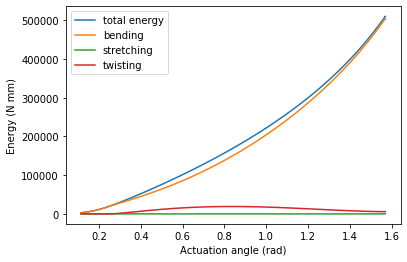

In [10]:
deployment_plots.energy_plot(preopt_tgtAngles, preopt_cr)

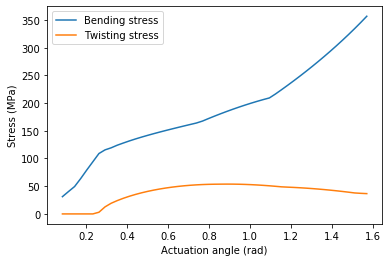

In [12]:
deployment_plots.stress_plot(preoptStressRecorder)

In [35]:
preoptStressRecorder.actuationAngle[29]

0.9460003923461963

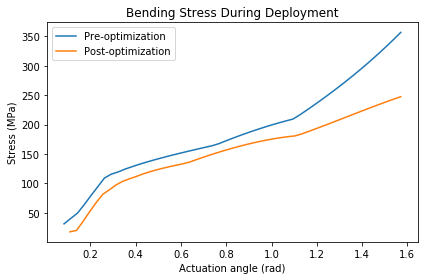

In [27]:
import importlib
importlib.reload(deployment_plots)
deployment_plots.bending_stress_comparison_plot_impl(preoptStressRecorder, 'Pre-optimization', postoptStressRecorder, 'Post-optimization')
plt.title('Bending Stress During Deployment')
plt.tight_layout()
plt.savefig('bending_stress.pdf')

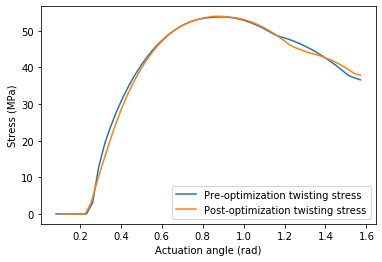

In [14]:
import importlib
importlib.reload(deployment_plots)
deployment_plots.twisting_stress_comparison_plot(preoptStressRecorder, 'Pre-optimization', postoptStressRecorder, 'Post-optimization')

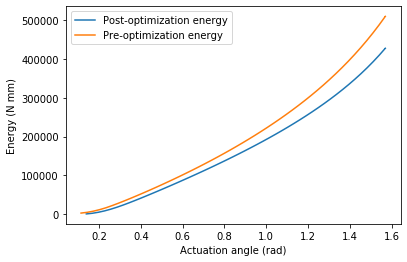

In [15]:
deployment_plots.energy_comparison_plot(tgtAngles, cr, 'Post-optimization', preopt_tgtAngles, preopt_cr, 'Pre-optimization')

## Analyze Hessian spectrum

In [15]:
import compute_vibrational_modes
fixedVarsWithoutActuator = fixedVars[:]
lambdas, modes = compute_vibrational_modes.compute_vibrational_modes(l, fixedVars=[], mtype=compute_vibrational_modes.MassMatrixType.FULL, n=16, sigma=-1e-6)

import mode_viewer, importlib
importlib.reload(mode_viewer);
mview = mode_viewer.ModeViewer(l, modes, lambdas, amplitude=5.0)
mview.show()